# IMDb and TMDb Movie Data Extraction
This notebook extracts and analyzes movie data from IMDb and TMDb. 
The workflow includes:
1. Fetching movie details from IMDb and TMDb.
2. Cleaning and formatting the data.
3. Exporting the results to CSV files.
4. Analysis on each dataset.
5. Combined both daatset.
6. Analysis on combined data.


### Datasource 1: Reviews

In [18]:
import requests
from bs4 import BeautifulSoup
import csv


In [ ]:
# Function to get IMDb movie IDs and names from the Top 250 page
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# URL of the IMDb Top 250 Movies page
top_250_url = 'https://www.imdb.com/chart/top'

def get_top_250_movies():
    movies = []
    
    # Send GET request to fetch the page
    try:
        response = requests.get(top_250_url, headers=headers)
        response.raise_for_status()  # Raise an exception for HTTP errors
        print("Top 250 Movies page fetched successfully!")
    except requests.exceptions.RequestException as e:
        print(f"Error fetching the Top 250 Movies page: {e}")
        return []
    
    # Parsing the page content using BeautifulSoup
    try:
        soup = BeautifulSoup(response.content, 'html.parser')
        print("Top 250 Movies page parsed successfully!")
    except Exception as e:
        print(f"Error parsing the page: {e}")
        return []
    
    
    rows = soup.select('.ipc-title--title')  # Adjusting for the IMDb structure
    
    # Extract the movie name and IMDb ID
    for row in rows[1:100]:  
        link_tag = row.find('a', href=True)  # Find the link to the movie
        if link_tag:
            href = link_tag['href']
            movie_id = href.split('/')[2]  
            movie_name_tag = row.find('h3', class_='ipc-title__text')  # Adjusted class name
            if movie_name_tag:
                raw_movie_name = movie_name_tag.text.strip()
                movie_name = raw_movie_name.split('. ', 1)[-1]
            else:
                movie_name = 'Unknown Title'
            
            if movie_id and movie_name:
                movies.append({'movie_id': movie_id, 'movie_name': movie_name})
    
    return movies



# Function to scrape reviews for a movie
def scrape_reviews(movie_id, movie_name):
    url = f'https://www.imdb.com/title/{movie_id}/reviews/?ref_=tt_ov_ql_2'
    
    # Send a GET request with headers
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Raise an exception for HTTP errors
        
    except requests.exceptions.RequestException as e:
        return []
    
    # Parsing the page content using BeautifulSoup
    try:
        soup = BeautifulSoup(response.content, 'html.parser')
       
    except Exception as e:
       
        return []

    # Find all review items on the page
    reviews = soup.find_all('article', class_='sc-f53ace6f-1 cHwTOl user-review-item')
    

    # Loop through each review and extract relevant information
    reviews_data = []
    for review in reviews:
        # Extract the review text
        review_text = review.find('div', class_='ipc-html-content-inner-div')
        # Extract the user rating
        user_rating = review.find('span', class_='ipc-rating-star--rating')
        # Extract the review date
        review_date = review.find('li', class_='review-date')

        # Handle missing data
        review_text = review_text.text.strip() if review_text else 'N/A'
        user_rating = user_rating.text.strip() if user_rating else 'N/A'
        review_date = review_date.text.strip() if review_date else 'N/A'

        # Store data in a dictionary
        review_data = {
            'movie_id': movie_id,
            'movie_name': movie_name,
            'review_text': review_text,
            'user_rating': user_rating,
            'review_date': review_date
        }
        
        reviews_data.append(review_data)

    return reviews_data

 

# Function to save reviews to CSV
def save_reviews_to_csv(reviews, filename='data/Reviews.csv'):
    fieldnames = ['movie_id', 'movie_name', 'review_text', 'user_rating', 'review_date']
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        for review in reviews:
            writer.writerow(review)
    print(f"Reviews saved to {filename}")

In [20]:
# Main execution for IMDb
movies = get_top_250_movies()

all_reviews = []

if movies:
    for movie in movies:
        reviews = scrape_reviews(movie['movie_id'], movie['movie_name'])
        all_reviews.extend(reviews)

# Save all reviews to CSV
save_reviews_to_csv(all_reviews)


Top 250 Movies page fetched successfully!
Top 250 Movies page parsed successfully!
Reviews saved to Reviews.csv


In [ ]:
import pandas as pd

# Load IMDb reviews dataset
imdb_reviews = pd.read_csv("data/Reviews.csv")


print(imdb_reviews.head())


    movie_id                movie_name  \
0  tt0111161  The Shawshank Redemption   
1  tt0111161  The Shawshank Redemption   
2  tt0111161  The Shawshank Redemption   
3  tt0111161  The Shawshank Redemption   
4  tt0111161  The Shawshank Redemption   

                                         review_text  user_rating  \
0                                                NaN         10.0   
1  It is no wonder that the film has such a high ...         10.0   
2  I'm trying to save you money; this is the last...         10.0   
3                                                NaN         10.0   
4  This movie is not your ordinary Hollywood flic...         10.0   

    review_date  
0  Jul 23, 2010  
1  Feb 16, 2021  
2  Nov 20, 2005  
3   Feb 9, 2006  
4  Feb 17, 2008  


In [22]:
imdb_reviews.isna().sum()

movie_id         0
movie_name       0
review_text    172
user_rating     54
review_date      0
dtype: int64

In [23]:
imdb_reviews.dropna(subset=['review_text', 'user_rating'], inplace=True)


In [24]:
imdb_reviews.isna().sum()

movie_id       0
movie_name     0
review_text    0
user_rating    0
review_date    0
dtype: int64

In [25]:
# !pip install seaborn

In [26]:
# !pip install wordcloud

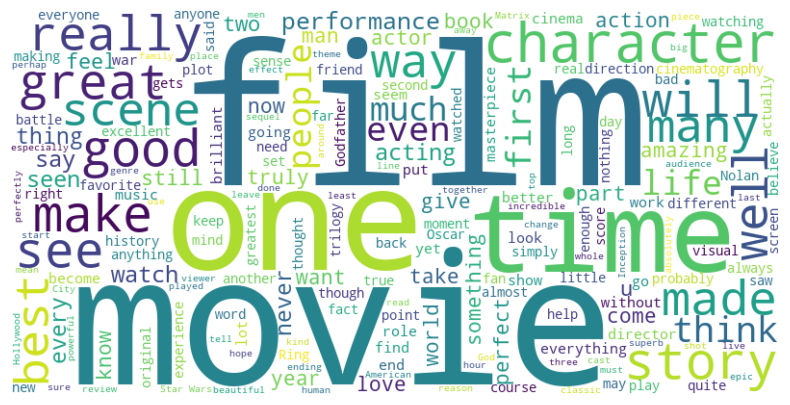

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Combine all review texts
all_reviews = ' '.join(imdb_reviews['review_text'].dropna())

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### Question 1: What is the average user rating and average user review count for each movie?

In [ ]:
# Count the number of reviews per movie
movie_summary = imdb_reviews.groupby('movie_name').agg(
    average_rating=('user_rating', 'mean'),
    review_count=('review_text', 'count')
).reset_index()
movie_summary.to_csv("data/q1.csv",index=False)
print(movie_summary)


                                           movie_name  average_rating  \
0                                        12 Angry Men        9.300000   
1                                         City of God        9.052632   
2                                          Fight Club        9.000000   
3                                        Forrest Gump        9.055556   
4                                          Goodfellas        9.500000   
5                                           Inception        9.692308   
6                                        Interstellar        9.315789   
7                               It's a Wonderful Life        9.117647   
8                     One Flew Over the Cuckoo's Nest        9.052632   
9                                        Pulp Fiction        8.823529   
10                                Saving Private Ryan        8.421053   
11                                   Schindler's List        9.600000   
12                                              Se7

In [29]:
from textblob import TextBlob
import pandas as pd
#function to generate sentiment score
def get_sentiment(review):
    analysis = TextBlob(review)
    return analysis.sentiment.polarity 
#creating the sentiment columns in reviews dataset
imdb_reviews['sentiment'] = imdb_reviews['review_text'].apply(get_sentiment)
imdb_reviews[['movie_name', 'review_text', 'sentiment']]

,movie_name,review_text,sentiment
1,The Shawshank Redemption,It is no wonder that the film has such a high ...,0.332727
2,The Shawshank Redemption,I'm trying to save you money; this is the last...,0.236772
4,The Shawshank Redemption,This movie is not your ordinary Hollywood flic...,0.308412
6,The Shawshank Redemption,The best movie in history and the best ending ...,1.000000
7,The Shawshank Redemption,"Can Hollywood, usually creating things for ent...",0.256086
...,...,...,...
616,City of God,"Before anyone says anything, hear me out. Acco...",0.173760
617,City of God,A no holds barred look at life in the slums of...,0.135145
618,City of God,"Wow, what a great movie! I'd heard plenty abou...",0.227849
619,City of God,The movie deals about children and adolescent ...,0.050116


### Question 2: What is sentiment category for each movie according to sentiment score?

In [ ]:
# Function to classify sentiment based on polarity
def get_sentiment_category(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Applying the function to create sentiment categories
imdb_reviews['sentiment_category'] = imdb_reviews['sentiment'].apply(get_sentiment_category)

# Checking the updated DataFrame
imdb_reviews[['movie_name', 'review_text', 'sentiment', 'sentiment_category']].head()

imdb_reviews[['movie_name', 'review_text', 'sentiment', 'sentiment_category']].to_csv("data/q2.csv",index=False)


In [31]:
# Filter movies with positive sentiment
positive_movies = imdb_reviews[imdb_reviews['sentiment_category'] == 'Positive']['movie_name'].unique()

# Filter movies with neutral sentiment
neutral_movies = imdb_reviews[imdb_reviews['sentiment_category'] == 'Neutral']['movie_name'].unique()

# Filter movies with negative sentiment
negative_movies = imdb_reviews[imdb_reviews['sentiment_category'] == 'Negative']['movie_name'].unique()

# Display the results
print("Positive Movies:", positive_movies)
print("---------------------------------------------------------------------------------------")
print("Neutral Movies:", neutral_movies)
print("---------------------------------------------------------------------------------------")
print("Negative Movies:", negative_movies)


Positive Movies: ['The Shawshank Redemption' 'The Godfather' 'The Dark Knight'
 'The Godfather Part II' '12 Angry Men'
 'The Lord of the Rings: The Return of the King' "Schindler's List"
 'Pulp Fiction' 'The Lord of the Rings: The Fellowship of the Ring'
 'The Good, the Bad and the Ugly' 'Forrest Gump'
 'The Lord of the Rings: The Two Towers' 'Fight Club' 'Inception'
 'Star Wars: Episode V - The Empire Strikes Back' 'The Matrix'
 'Goodfellas' "One Flew Over the Cuckoo's Nest" 'Interstellar' 'Se7en'
 "It's a Wonderful Life" 'Seven Samurai' 'The Silence of the Lambs'
 'Saving Private Ryan' 'City of God']
---------------------------------------------------------------------------------------
Neutral Movies: ['12 Angry Men' 'Pulp Fiction' 'Fight Club' 'The Matrix' 'Interstellar']
---------------------------------------------------------------------------------------
Negative Movies: ['The Shawshank Redemption' 'The Godfather' '12 Angry Men'
 'The Lord of the Rings: The Return of the King' 

In [32]:
# !pip install textblob

### Datasource 2: Revenue

In [ ]:
import requests
from bs4 import BeautifulSoup
from dotenv import load_dotenv
import os
import csv

# TMDb API key 
api_key = os.getenv('TMDB_API_KEY')

# Define headers to mimic a real browser
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# Base URL for TMDb Top Rated Movies page
base_url = 'https://www.themoviedb.org/movie/top-rated'

# Function to fetch movie IDs and names from a single page
def get_movie_ids_and_names_from_page(page):
    movies = []
    url = f"{base_url}?page={page}"
    
    # Send GET request to the page
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching page {page}: {e}")
        return []

    # Parsing the page content with BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all <div class="content"> elements
    content_divs = soup.find_all('div', class_='content')
    for content in content_divs:
        # Safely check for <h2> tag
        h2_tag = content.find('h2')
        if h2_tag:
            # Extract movie link
            movie_link = h2_tag.find('a', href=True)
            if movie_link:
                href = movie_link['href']
                movie_id = href.split('/')[2].split('-')[0]  # Extract movie ID
                movie_name = movie_link.text.strip()
                movies.append((movie_id, movie_name))  # Store as a tuple

    return movies

# Function to fetch movie details from TMDb API
def fetch_movie_details(movie_id):
    movie_url = f'https://api.themoviedb.org/3/movie/{movie_id}?api_key={api_key}'
    try:
        response = requests.get(movie_url)
        response.raise_for_status()
        movie_data = response.json()
        revenue = movie_data.get('revenue', 'N/A')
        user_score = movie_data.get('vote_average', 'N/A')
        return revenue, user_score
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching details for movie ID {movie_id}: {e}")
        return 'N/A', 'N/A'

# Main execution
def scrape_all_movies(max_pages=10):
    all_movies = []

    # Open CSV file to save the results
    with open('data/Revenue.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        # Write CSV header
        writer.writerow(['Movie ID', 'movie_name', 'Revenue', 'User Score'])

        for page in range(1, max_pages + 1):
            print(f"Fetching movies from page {page}...")
            movies = get_movie_ids_and_names_from_page(page)
            if not movies:
                print(f"No movies found on page {page}. Stopping.")
                break
            all_movies.extend(movies)

            # Fetch details for each movie
            for movie_id, movie_name in movies:
                revenue, user_score = fetch_movie_details(movie_id)
                print(f"Movie ID: {movie_id}, Name: {movie_name}, Revenue: {revenue}, User Score: {user_score}")
                # Write row to CSV
                writer.writerow([movie_id, movie_name, revenue, user_score])

    print("Data saved to Revenue.csv")

In [34]:
# Main execution for TMDb
scrape_all_movies(max_pages=10) 


Fetching movies from page 1...
Movie ID: 278, Name: The Shawshank Redemption, Revenue: 28341469, User Score: 8.707
Movie ID: 238, Name: The Godfather, Revenue: 245066411, User Score: 8.7
Movie ID: 240, Name: The Godfather Part II, Revenue: 102600000, User Score: 8.6
Movie ID: 424, Name: Schindler's List, Revenue: 321365567, User Score: 8.566
Movie ID: 389, Name: 12 Angry Men, Revenue: 4360000, User Score: 8.5
Movie ID: 129, Name: Spirited Away, Revenue: 274925095, User Score: 8.5
Movie ID: 19404, Name: Dilwale Dulhania Le Jayenge, Revenue: 100000000, User Score: 8.527
Movie ID: 155, Name: The Dark Knight, Revenue: 1004558444, User Score: 8.516
Movie ID: 497, Name: The Green Mile, Revenue: 286801374, User Score: 8.5
Movie ID: 496243, Name: Parasite, Revenue: 257591776, User Score: 8.5
Movie ID: 680, Name: Pulp Fiction, Revenue: 213928762, User Score: 8.488
Movie ID: 372058, Name: Your Name., Revenue: 358000000, User Score: 8.5
Movie ID: 122, Name: The Lord of the Rings: The Return of th

In [ ]:
import pandas as pd

# Load IMDb revenue dataset
imdb_revenue = pd.read_csv("data/Revenue.csv")

# Display the first few rows
imdb_revenue.head()

,Movie ID,movie_name,Revenue,User Score
0,278,The Shawshank Redemption,28341469,8.707
1,238,The Godfather,245066411,8.700
2,240,The Godfather Part II,102600000,8.600
3,424,Schindler's List,321365567,8.566
4,389,12 Angry Men,4360000,8.500


In [36]:
imdb_revenue.isna().sum()

Movie ID      0
movie_name    0
Revenue       0
User Score    0
dtype: int64

In [37]:
# Identify underperforming movies (High User Score, Low Revenue)
underperforming_movies = imdb_revenue[(imdb_revenue['User Score'] > 7) & (imdb_revenue['Revenue'] < 2000000)]
# Display results
print("Underperforming Movies (High Score, Low Revenue):\n", underperforming_movies[['movie_name', 'Revenue', 'User Score']])


Underperforming Movies (High Score, Low Revenue):
                                      movie_name  Revenue  User Score
13     David Attenborough: A Life on Our Planet        0       8.473
18                       Grave of the Fireflies   516962       8.456
24                            Impossible Things        0       8.436
30                            Gabriel's Inferno        0       8.400
32                    Burn the Stage: The Movie        0       8.400
..                                          ...      ...         ...
188                               Purple Hearts        0       8.120
191                                  Metropolis  1350322       8.120
194                               The Great War        0       8.100
196  “The Shorts” by Aldo, Giovanni and Giacomo        0       8.100
199                       The Salt of the Earth  1059804       8.115

[64 rows x 3 columns]


In [38]:
# Top movies by average user rating
top_rated_movies = imdb_reviews.groupby('movie_name')['user_rating'].mean().reset_index()
top_rated_movies = top_rated_movies.sort_values(by='user_rating', ascending=False).head(10)

# Top movies by worldwide revenue
top_grossing_movies = imdb_revenue.sort_values(by='Revenue', ascending=False).head(10)

# Display the results
print("Top Rated Movies:\n", top_rated_movies)
print("----------------------------------------------------------------------------")
print("Top Grossing Movies:\n", top_grossing_movies)

Top Rated Movies:
                         movie_name  user_rating
5                        Inception     9.692308
11                Schindler's List     9.600000
4                       Goodfellas     9.500000
22                      The Matrix     9.437500
15                 The Dark Knight     9.375000
12                           Se7en     9.363636
18  The Good, the Bad and the Ugly     9.333333
6                     Interstellar     9.315789
0                     12 Angry Men     9.300000
16                   The Godfather     9.266667
----------------------------------------------------------------------------
Top Grossing Movies:
      Movie ID                                         movie_name     Revenue  \
96     299534                                  Avengers: Endgame  2799439100   
98     299536                             Avengers: Infinity War  2052415039   
128    361743                                  Top Gun: Maverick  1488732821   
12        122      The Lord of the


## Combined review data and revenu data on movie name.

In [39]:
#merge both dataset on common column 'movie_name'
combined = pd.merge(imdb_revenue, imdb_reviews, on='movie_name', how='inner')
combined.head()

,Movie ID,movie_name,Revenue,User Score,movie_id,review_text,user_rating,review_date,sentiment,sentiment_category
0,278,The Shawshank Redemption,28341469,8.707,tt0111161,It is no wonder that the film has such a high ...,10.0,"Feb 16, 2021",0.332727,Positive
1,278,The Shawshank Redemption,28341469,8.707,tt0111161,I'm trying to save you money; this is the last...,10.0,"Nov 20, 2005",0.236772,Positive
2,278,The Shawshank Redemption,28341469,8.707,tt0111161,This movie is not your ordinary Hollywood flic...,10.0,"Feb 17, 2008",0.308412,Positive
3,278,The Shawshank Redemption,28341469,8.707,tt0111161,The best movie in history and the best ending ...,10.0,"Oct 7, 2020",1.000000,Positive
4,278,The Shawshank Redemption,28341469,8.707,tt0111161,"Can Hollywood, usually creating things for ent...",10.0,"Aug 26, 2002",0.256086,Positive


In [40]:
#droping column User Score because both dataset had user rating column
combined.drop(columns=['User Score'],inplace=True)


In [41]:
combined.head()

,Movie ID,movie_name,Revenue,movie_id,review_text,user_rating,review_date,sentiment,sentiment_category
0,278,The Shawshank Redemption,28341469,tt0111161,It is no wonder that the film has such a high ...,10.0,"Feb 16, 2021",0.332727,Positive
1,278,The Shawshank Redemption,28341469,tt0111161,I'm trying to save you money; this is the last...,10.0,"Nov 20, 2005",0.236772,Positive
2,278,The Shawshank Redemption,28341469,tt0111161,This movie is not your ordinary Hollywood flic...,10.0,"Feb 17, 2008",0.308412,Positive
3,278,The Shawshank Redemption,28341469,tt0111161,The best movie in history and the best ending ...,10.0,"Oct 7, 2020",1.000000,Positive
4,278,The Shawshank Redemption,28341469,tt0111161,"Can Hollywood, usually creating things for ent...",10.0,"Aug 26, 2002",0.256086,Positive


In [42]:
#taking columns from combined data for sentiment analysis ahead. 
sentiment_Data=combined[['movie_name', 'sentiment_category', 'Revenue']]
sentiment_Data

,movie_name,sentiment_category,Revenue
0,The Shawshank Redemption,Positive,28341469
1,The Shawshank Redemption,Positive,28341469
2,The Shawshank Redemption,Positive,28341469
3,The Shawshank Redemption,Positive,28341469
4,The Shawshank Redemption,Positive,28341469
...,...,...,...
370,Saving Private Ryan,Positive,481840909
371,Saving Private Ryan,Positive,481840909
372,Saving Private Ryan,Positive,481840909
373,Saving Private Ryan,Positive,481840909


### Question 3: What is the total revenue and average user rating for each sentiment category?

In [ ]:
sentiment_impact = combined.groupby('sentiment_category').agg(
    total_revenue=('Revenue', 'sum'),
    avg_user_rating=('user_rating', 'mean')
).reset_index()

# Display results
print(sentiment_impact)
sentiment_impact.to_csv("data/q3.csv",index=False)

  sentiment_category  total_revenue  avg_user_rating
0           Negative     5334224033         8.285714
1            Neutral     1698317866        10.000000
2           Positive   140246831022         9.126761


## Conclusion
1. The IMDb scraping process fetched movie reviews and saved them to `Reviews.csv`.
2. The TMDb scraping process fetched top-rated movie data and saved them to `Revenue.csv`.
3. Did analysis on both dataset seprately and then combined the dataset. 
4. After combining the dataset again did analysis on that dataset.

You can find the results in the respective CSV files.
